In [1]:
import sys
import numpy as np
import pandas as pd
import librosa as lr
import librosa.display as lrd
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import Audio
from pydub import AudioSegment, effects
import noisereduce as nr
from tqdm import tqdm
from sklearn.utils import shuffle
from tqdm import tqdm
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain, PolarityInversion, TimeMask, FrequencyMask, SpecFrequencyMask, RoomSimulator, AddBackgroundNoise
import os
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# total_length = 423936
# total_length = 208384
# total_length = 70656
frame_length = 2048
hop_length = 512
TOP_DB = 30
RATE = 48000


In [3]:
def get_emotion_identifier(emotion):
    if emotion == 'neutral' or emotion == '01':
        return 0
    elif emotion == 'calm' or emotion == '02':
        return 1
    elif emotion == 'happy' or emotion == '03':
        return 2
    elif emotion == 'sad' or emotion == '04':
        return 3
    elif emotion == 'angry' or emotion == '05':
        return 4
    elif emotion == 'fearful' or emotion == 'fear' or emotion == '06':
        return 5
    elif emotion == 'disgust' or emotion == '07':
        return 6
    elif emotion == 'surprised' or emotion == 'surprise' or emotion == 'ps' or emotion == '08':
        return 7
    else:
        raise ValueError('Emotion not found')

#### Load BanglaSER Dataset

In [2]:
# dataset = '../Datasets/BanglaSER/'

# files = []
# emo = []

# def getEmotion(i):
#     if i == '01':
#         return 'happy'
#     elif i == '02':
#         return 'sad'
#     elif i == '03':
#         return 'angry'
#     elif i == '04':
#         return 'surprise'
#     elif i == '05':
#         return 'neutral'
#     else :
#         return 'error'


# for dirpath, dirnames, filenames in os.walk(dataset):
#     for filename in filenames:
#         files.append(os.path.join(dirpath, filename))
#         x = filename.split('-')[2]
#         emo.append(getEmotion(x))


# files
# emo

#### Load SUBESCO Dataset

In [69]:
# dataset = '../Datasets/SUBESCO/'

# files_m = []
# emo_m = []
# files_f = []
# emo_f = []
# segment_lengths = []

# for dirpath, dirnames, filenames in os.walk(dataset):
#     # print(dirnames, filenames)
#     for filename in tqdm(filenames):

#         splits = filename.split('_')

#         x = os.path.join(dirpath, filename)
#         y = splits[-2].lower()
#         z = splits[0].lower()


#         if z == 'm':
#             files_m.append(x)
#             emo_m.append(y)
#         elif z == 'f':
#             files_f.append(x)
#             emo_f.append(y)
#         else:
#             print('error', z)
#             sys.exit()

#         # gender.append(z)

#         data, _ = lr.load(x, sr=RATE, res_type='kaiser_fast')
#         data, _ = lr.effects.trim(data, top_db=TOP_DB)
#         segment_lengths.append(len(data))


# # print(f'Total {len(files)} files loaded')
# print('Max segment length: ', max(segment_lengths))

100%|██████████| 7000/7000 [05:34<00:00, 20.93it/s]

Max segment length:  70656


### RAVDESS

In [30]:
dataset = '../Datasets/ravdess'

files_m = []
emo_m = []
files_f = []
emo_f = []
segment_lengths = []

for dirpath, dirnames, filenames in os.walk(dataset):
    for filename in tqdm(filenames):

        splits = filename.split('-')

        sound = os.path.join(dirpath, filename)

        emotion = int(splits[2])

        gender = splits[-1].split('.')[0]


        if int(gender) % 2 != 0 :
            files_m.append(sound)
            emo_m.append(emotion)
        else:
            files_f.append(sound)
            emo_f.append(emotion)


        data, _ = lr.load(sound, sr=RATE, res_type='kaiser_best')
        data, _ = lr.effects.trim(data, top_db=TOP_DB)
        segment_lengths.append(len(data))


print(f'Total {len(files_m) + len(files_f)} files loaded')
max_length = max(segment_lengths)
print('Max segment length: ', max_length)

0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 214.53it/s]

Total 1440 files loaded
Max segment length:  204288


In [5]:
files_m[:10], emo_m[:10]

(['../Datasets/ravdess\\Actor_01\\03-01-01-01-01-01-01.wav',
  '../Datasets/ravdess\\Actor_01\\03-01-01-01-01-02-01.wav',
  '../Datasets/ravdess\\Actor_01\\03-01-01-01-02-01-01.wav',
  '../Datasets/ravdess\\Actor_01\\03-01-01-01-02-02-01.wav',
  '../Datasets/ravdess\\Actor_01\\03-01-02-01-01-01-01.wav',
  '../Datasets/ravdess\\Actor_01\\03-01-02-01-01-02-01.wav',
  '../Datasets/ravdess\\Actor_01\\03-01-02-01-02-01-01.wav',
  '../Datasets/ravdess\\Actor_01\\03-01-02-01-02-02-01.wav',
  '../Datasets/ravdess\\Actor_01\\03-01-02-02-01-01-01.wav',
  '../Datasets/ravdess\\Actor_01\\03-01-02-02-01-02-01.wav'],
 [1, 1, 1, 1, 2, 2, 2, 2, 2, 2])

In [6]:
files_f[:10], emo_f[:10]

(['../Datasets/ravdess\\Actor_02\\03-01-01-01-01-01-02.wav',
  '../Datasets/ravdess\\Actor_02\\03-01-01-01-01-02-02.wav',
  '../Datasets/ravdess\\Actor_02\\03-01-01-01-02-01-02.wav',
  '../Datasets/ravdess\\Actor_02\\03-01-01-01-02-02-02.wav',
  '../Datasets/ravdess\\Actor_02\\03-01-02-01-01-01-02.wav',
  '../Datasets/ravdess\\Actor_02\\03-01-02-01-01-02-02.wav',
  '../Datasets/ravdess\\Actor_02\\03-01-02-01-02-01-02.wav',
  '../Datasets/ravdess\\Actor_02\\03-01-02-01-02-02-02.wav',
  '../Datasets/ravdess\\Actor_02\\03-01-02-02-01-01-02.wav',
  '../Datasets/ravdess\\Actor_02\\03-01-02-02-01-02-02.wav'],
 [1, 1, 1, 1, 2, 2, 2, 2, 2, 2])

#### Load TESS Dataset

In [5]:
# dataset = '/content/drive/MyDrive/Datasets/tess'

# files = []
# emo = []

# for dirpath, dirnames, filenames in os.walk(dataset):
#     # print(dirnames, filenames)
#     for filename in filenames:
#         x = os.path.join(dirpath, filename)
#         files.append(x)
#         y = x.split('_')[-1].split('.')[0].lower()
#         emo.append(y)

In [31]:
d_m = pd.DataFrame()
d_m['sound'] = files_m
d_m['emotion'] = emo_m

d_m.sample(10)

sound  emotion
222  ../Datasets/ravdess\Actor_07\03-01-06-02-02-01...        6
401  ../Datasets/ravdess\Actor_13\03-01-06-02-01-02...        6
46   ../Datasets/ravdess\Actor_01\03-01-07-01-02-01...        7
425  ../Datasets/ravdess\Actor_15\03-01-02-01-01-02...        2
168  ../Datasets/ravdess\Actor_05\03-01-07-02-01-01...        7
666  ../Datasets/ravdess\Actor_23\03-01-02-01-02-01...        2
398  ../Datasets/ravdess\Actor_13\03-01-06-01-02-01...        6
71   ../Datasets/ravdess\Actor_03\03-01-02-02-02-02...        2
113  ../Datasets/ravdess\Actor_03\03-01-08-01-01-02...        8
367  ../Datasets/ravdess\Actor_13\03-01-02-01-02-02...        2

In [32]:
d_f = pd.DataFrame()
d_f['sound'] = files_f
d_f['emotion'] = emo_f

d_f.sample(10)

sound  emotion
684  ../Datasets/ravdess\Actor_24\03-01-04-02-01-01...        4
590  ../Datasets/ravdess\Actor_20\03-01-07-02-02-01...        7
383  ../Datasets/ravdess\Actor_14\03-01-04-01-02-02...        4
420  ../Datasets/ravdess\Actor_16\03-01-01-01-01-01...        1
407  ../Datasets/ravdess\Actor_14\03-01-07-01-02-02...        7
385  ../Datasets/ravdess\Actor_14\03-01-04-02-01-02...        4
355  ../Datasets/ravdess\Actor_12\03-01-08-01-02-02...        8
633  ../Datasets/ravdess\Actor_22\03-01-05-02-01-02...        5
372  ../Datasets/ravdess\Actor_14\03-01-03-01-01-01...        3
32   ../Datasets/ravdess\Actor_02\03-01-05-02-01-01...        5

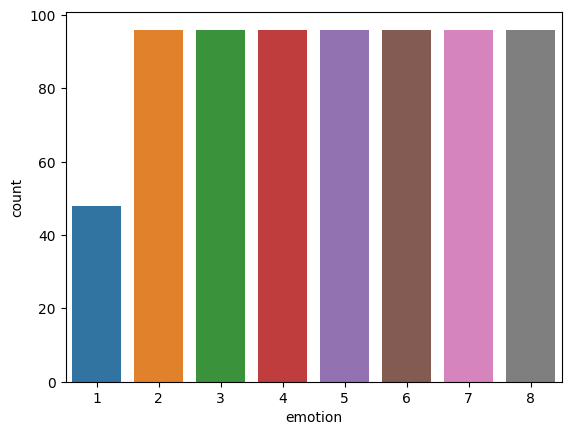

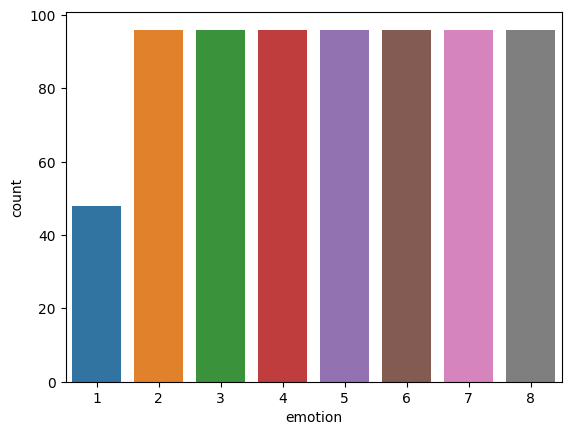

In [33]:
gm = sb.countplot(x='emotion', data=d_m)
# gm.fig.suptitle("Male")
plt.show()
gf = sb.countplot(x='emotion', data=d_f)
# gf.fig.suptitle("Female")
plt.show()
# g = sb.catplot(x='emotion', col='gender', data=d, kind='count', height=4, aspect=1.5, hue='gender')
# g.fig.suptitle("Sample distribution")
# g.fig.subplots_adjust(top=.8)
# plt.show()

In [34]:
print('Max sample length (will be used for padding later): ', max_length)
print('Sequential Values for each feature (rounded): ', round((max_length+1)/512))

Max sample length (will be used for padding later):  204288
Sequential Values for each feature (rounded):  399


#### ERD

In [12]:
def waveplot(data, sr, title):
    plt.figure(figsize=(12, 4))
    plt.title(title)
    lrd.waveshow(data, sr=sr)
    plt.show()

def spectograph(data, sr, title):
    x = lr.stft(data)
    xdb = lr.amplitude_to_db(abs(x))
    plt.figure(figsize=(12, 4))
    plt.title(title)
    lrd.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

def getPath(EType, gender):
    print(EType)
    if gender == 'm':
        return np.array(d_m['sound'][d_m['emotion'] == EType])[0]
    else:
        return np.array(d_f['sound'][d_f['emotion'] == EType])[0]

def getInfo(EType):
    path = getPath(EType, 'm')
    data, sr = lr.load(path)
    waveplot(data, sr, EType)
    spectograph(data, sr, EType)


2


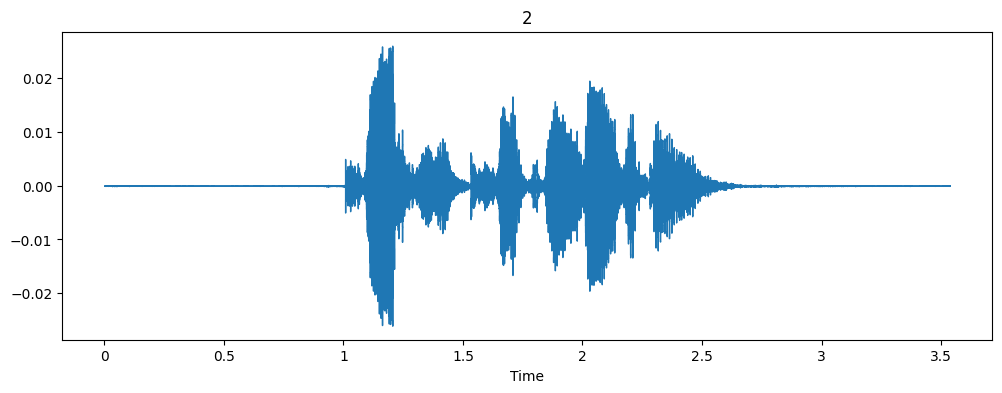

2


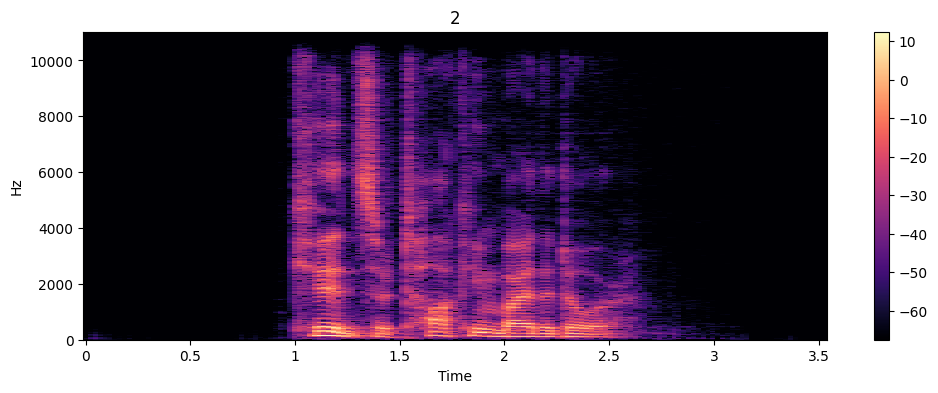

In [54]:
EType = 'happy'
getInfo(get_emotion_identifier(EType))
Audio(getPath(get_emotion_identifier(EType), 'm'))

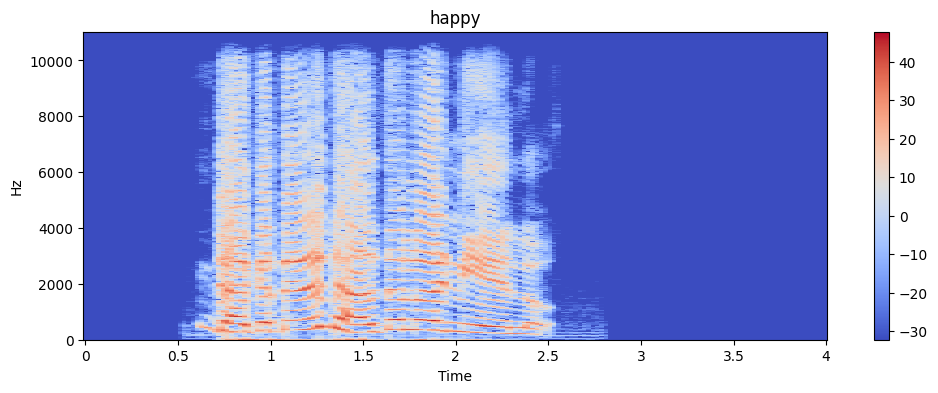

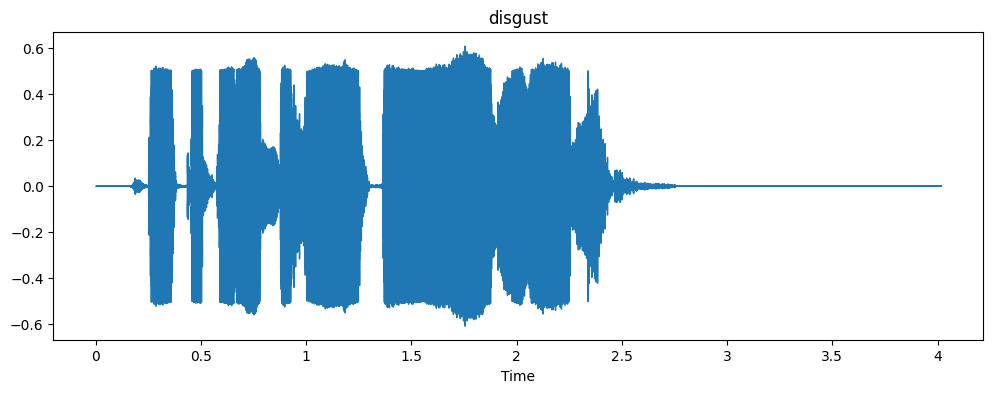

In [10]:
EType = 'disgust'
getInfo(EType)
Audio(getPath(EType))

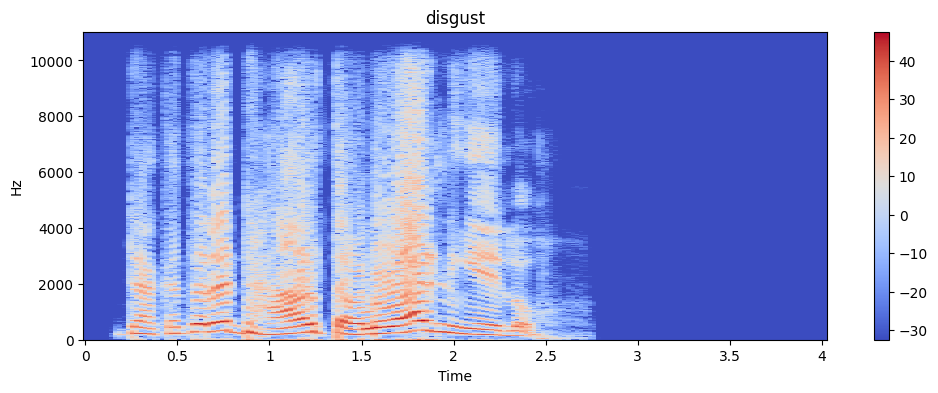

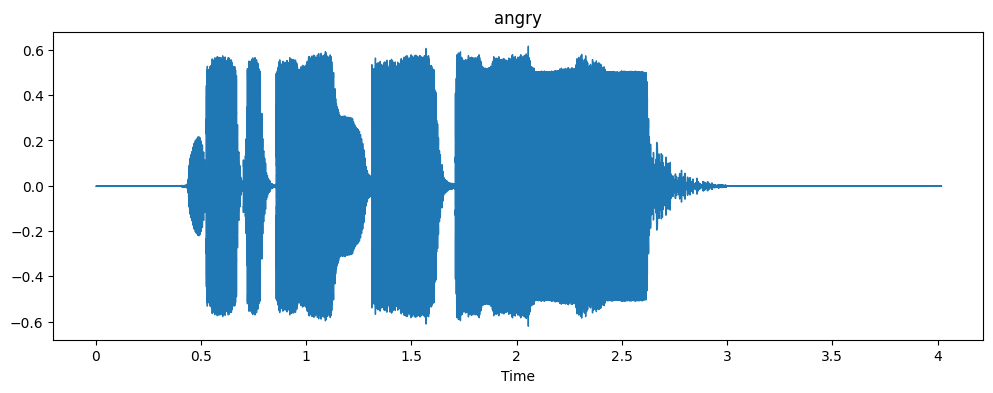

In [11]:
EType = 'angry'
getInfo(EType)
Audio(getPath(EType))

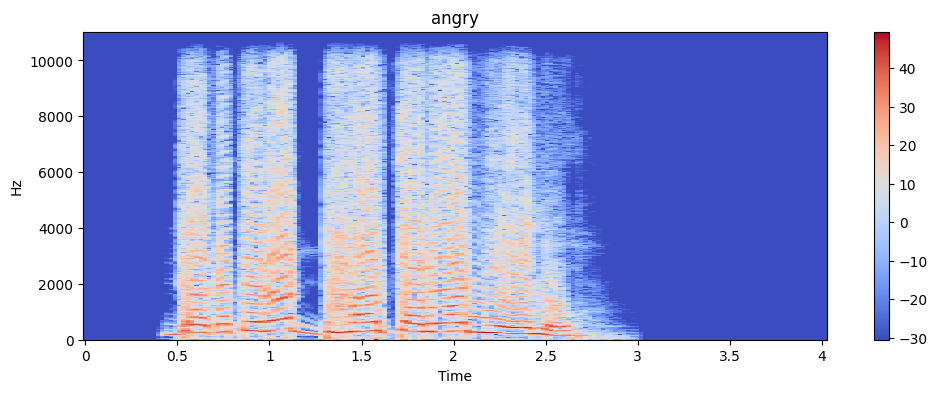

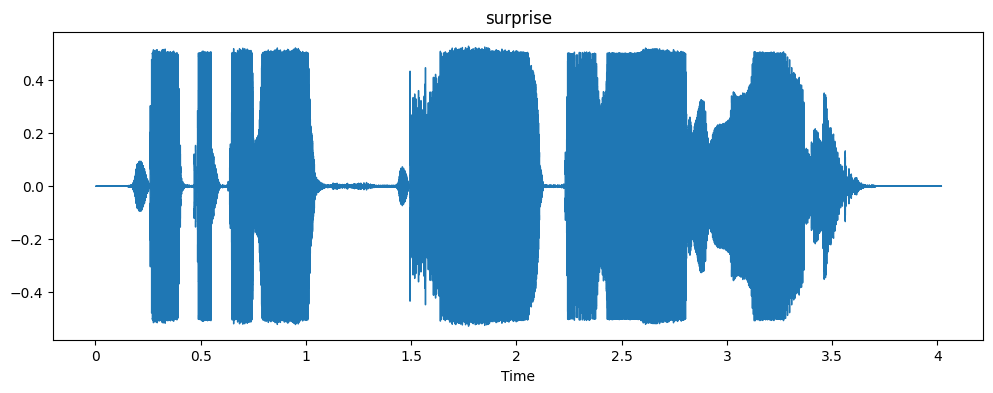

In [12]:
EType = 'surprise'
getInfo(EType)
Audio(getPath(EType))

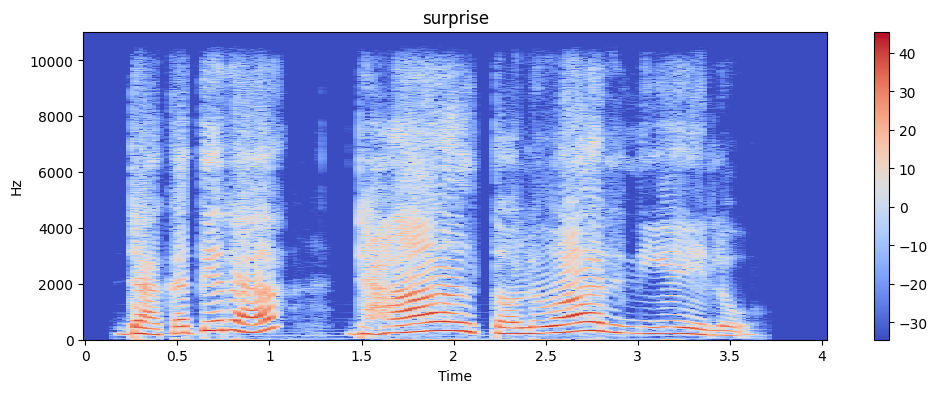

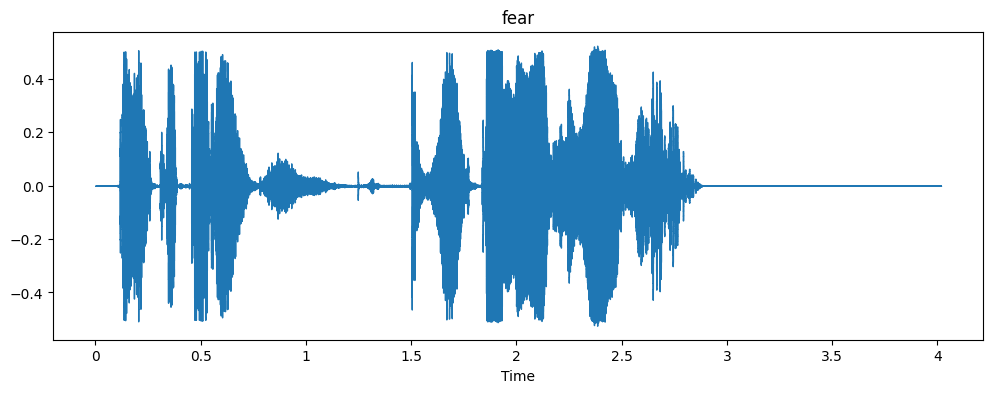

In [13]:
EType = 'fear'
getInfo(EType)
Audio(getPath(EType))

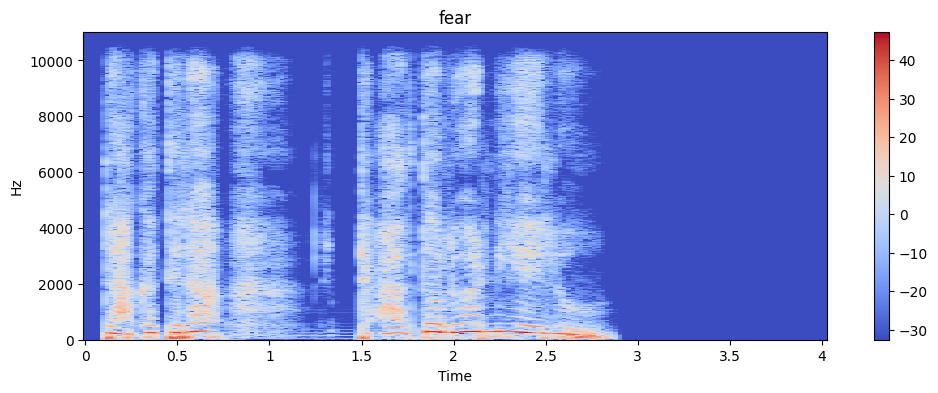

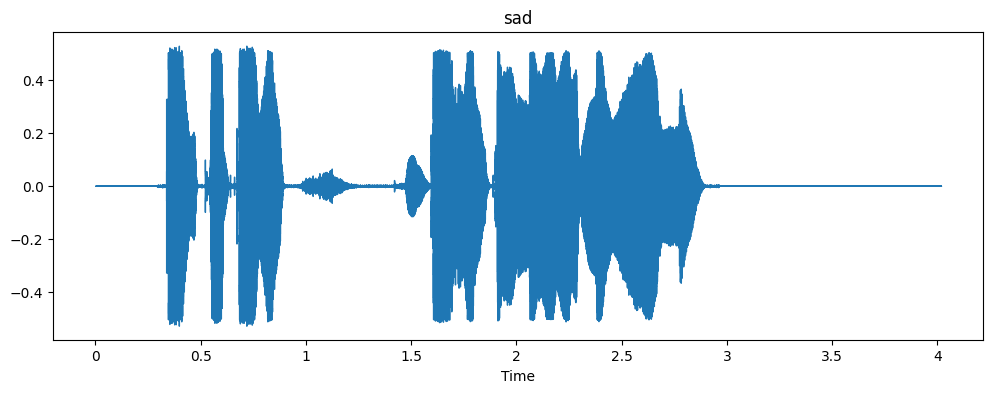

In [14]:
EType = 'sad'
getInfo(EType)
Audio(getPath(EType))

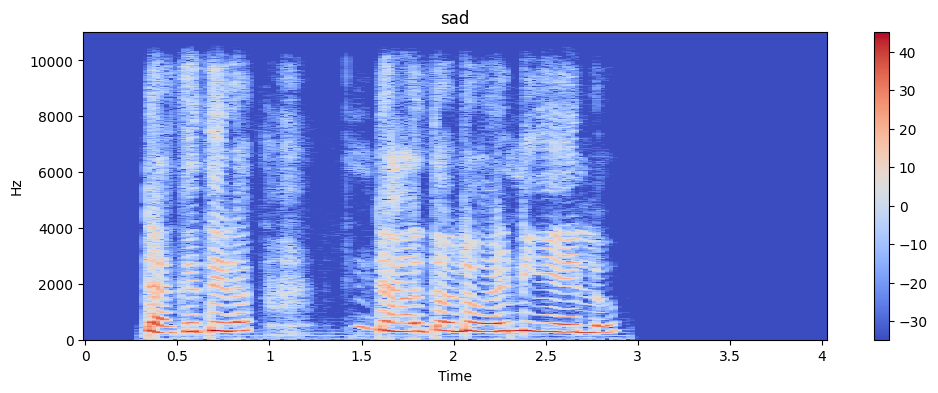

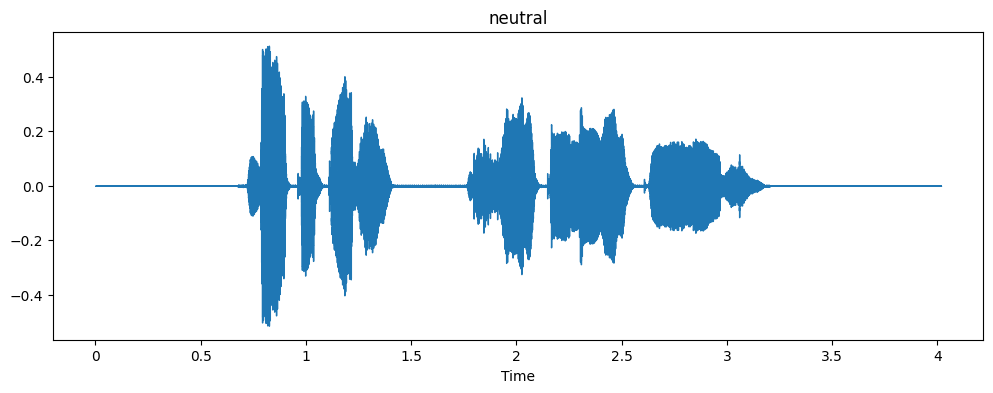

In [15]:
EType = 'neutral'
getInfo(EType)
Audio(getPath(EType))

# Data Augmentation

In [35]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return lr.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return lr.effects.pitch_shift(data, sampling_rate, pitch_factor)

## Data Augmentation Exhibition

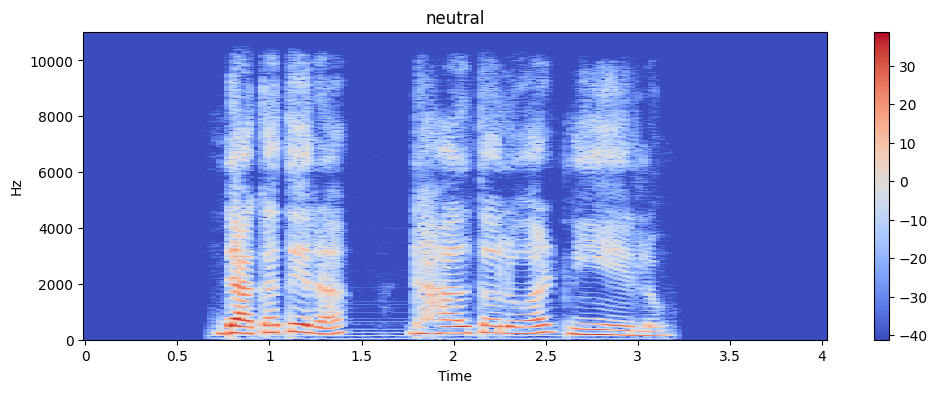

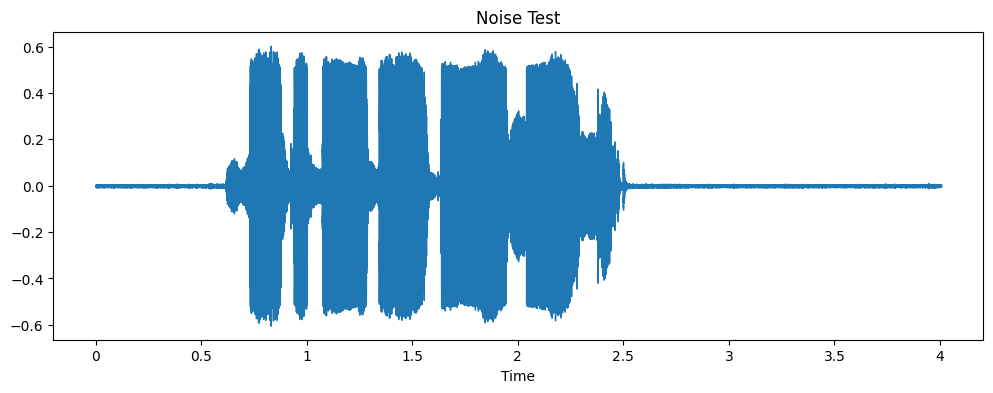

In [17]:
path = getPath('happy')
data, sr = lr.load(path)
x = noise(data)
waveplot(x, sr, 'Noise Test')
spectograph(x, sr, 'Noise Test')
Audio(x, rate=sr)

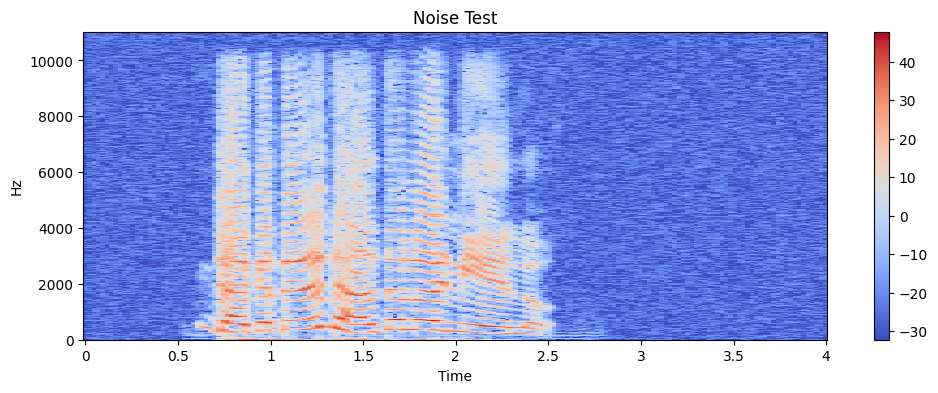

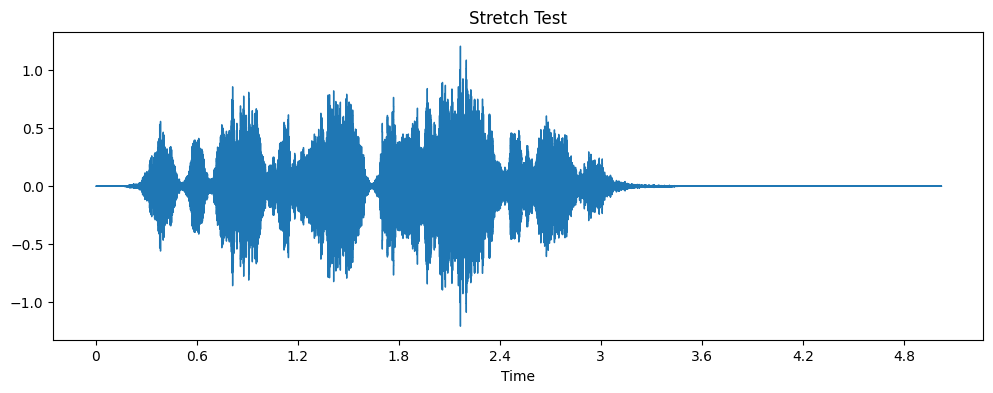

In [18]:
path = getPath('disgust')
data, sr = lr.load(path)
x = stretch(data)
waveplot(x, sr, 'Stretch Test')
spectograph(x, sr, 'Stretch Test')
Audio(x, rate=sr)

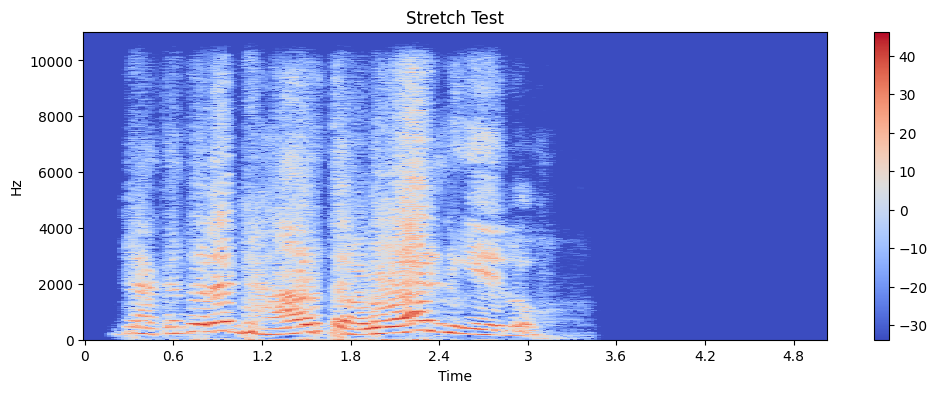

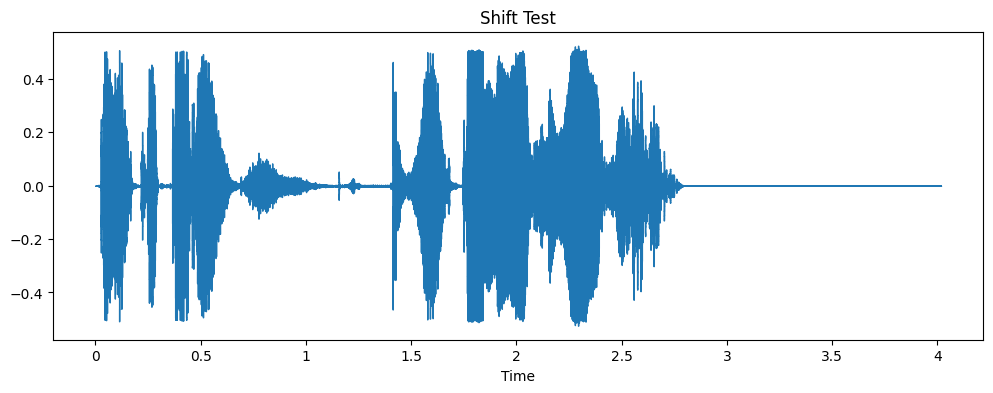

In [19]:
path = getPath('fear')
data, sr = lr.load(path)
x = shift(data)
waveplot(x, sr, 'Shift Test')
spectograph(x, sr, 'Shift Test')
Audio(x, rate=sr)

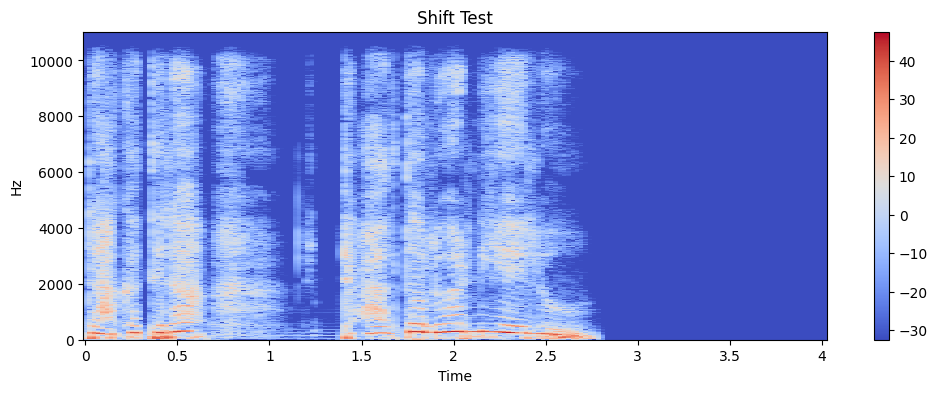

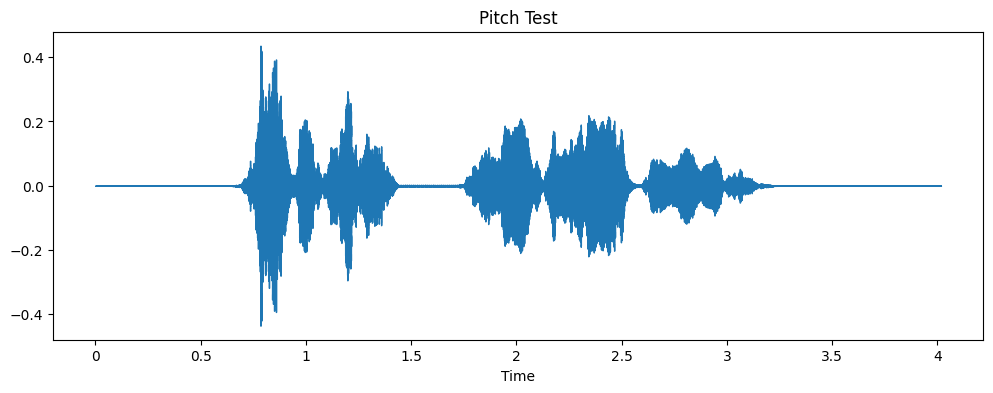

In [20]:
path = getPath('neutral')
data, sr = lr.load(path)
x = pitch(data, sr)
waveplot(x, sr, 'Pitch Test')
spectograph(x, sr, 'Pitch Test')
Audio(x, rate=sr)

In [21]:
## Shuffling
# d = d.sample(frac=1).reset_index(drop=True)
# d.head()

# Pre-processing

In [22]:
# def find_biggest_length(files):

#     sample_lengths = []

#     for file in tqdm(files):

#         # Load the audio file.
#         rawsound = AudioSegment.from_file(file) 

#         # Normalize the audio to +5.0 dBFS.
#         normalizedsound = effects.normalize(rawsound, headroom = 0) 
    
#         # Transform the normalized audio to np.array of samples.
#         data = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
#         xt, index = lr.effects.trim(data, top_db=30)

#         sample_lengths.append(len(xt)) # Unaugmented length


#         noisy_data = noise(data)
#         xt, index = lr.effects.trim(noisy_data, top_db=30) 
#         sample_lengths.append(len(xt)) # Noisy length


#         new_data = stretch(data)
#         stretched_and_pitched_data = pitch(new_data, sr)
#         xt, index = lr.effects.trim(stretched_and_pitched_data, top_db=30)
#         sample_lengths.append(len(xt)) # Stretch and pitch length

#     return np.max(sample_lengths)

3


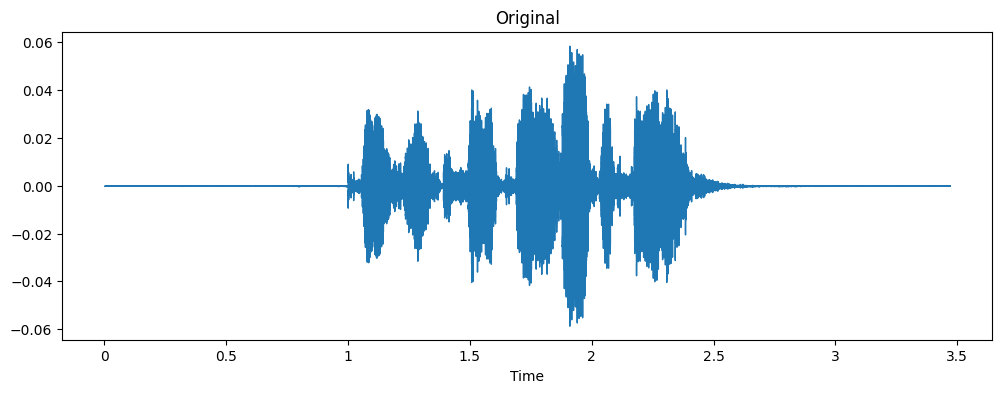

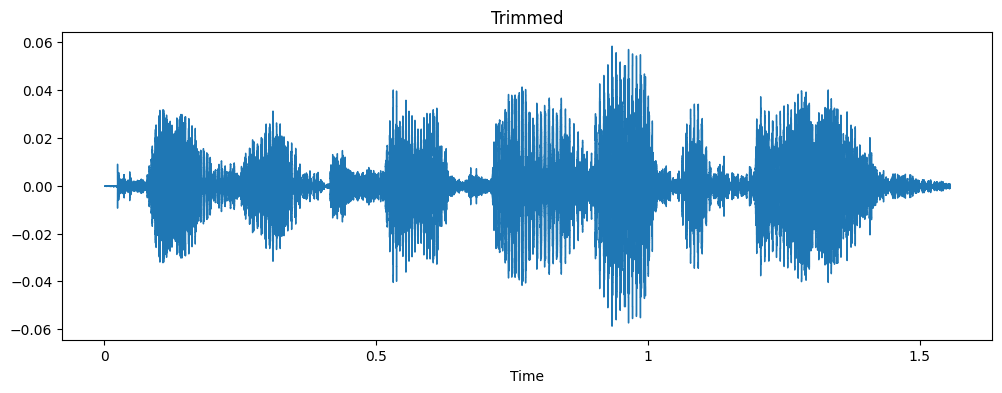

In [13]:
data, sr = lr.load(getPath(3, 'm'))
waveplot(data, sr, 'Original')
data_t = lr.effects.trim(data, top_db=TOP_DB)
waveplot(data_t[0], sr, 'Trimmed')

In [15]:
def pre_process(path, isNoise: bool = False, isPitch: bool = False):

    if isNoise and isPitch:
        raise ValueError('Cannot have both noise and pitch at the same time')

    data, sr = lr.load(path = path, sr=RATE, res_type='kaiser_best')

    # data with noise
    if isNoise:
        data = noise(data)

    # data with stretching and pitching
    if isPitch:
        new_data = stretch(data)
        data = pitch(new_data, sr)

    # # Load the audio file.
    # rawsound = AudioSegment.from_file(path) 

    # # Normalize the audio to +5.0 dBFS.
    # normalizedsound = effects.normalize(rawsound, headroom = 0) 
    
    # # Transform the normalized audio to np.array of samples.
    # normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')



    # Trim silence from the beginning and the end.
    xt, index = lr.effects.trim(data, top_db=TOP_DB)

    # Pad for duration equalization.
    data = np.pad(xt, (0, max_length-len(xt)), 'constant')

    if isNoise:
        return data

    # Noise reduction.
    # final_x = nr.reduce_noise(padded_x, sr=sr)

    return data, sr

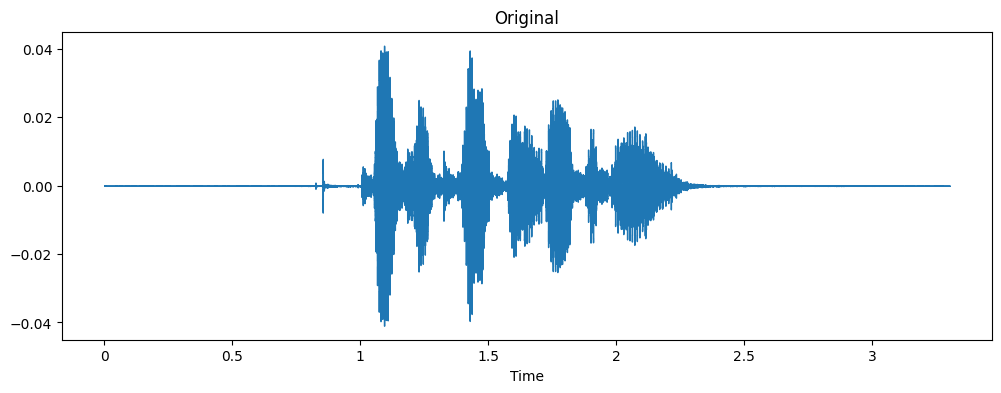

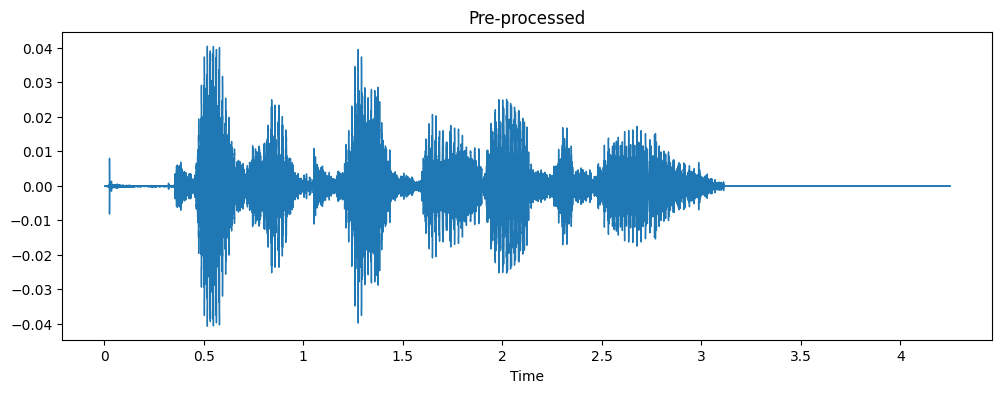

In [17]:
x = d_m['sound'][0]
data, sr = lr.load(x)
waveplot(data, sr, 'Original')
data_t = pre_process(x)
waveplot(data_t[0], sr, 'Pre-processed')

# Feature Extraction

In [42]:
def get_features(path, isNoise: bool = False, isPitch: bool = False):
    data, sr = pre_process(path, isNoise, isPitch)
    return extract_features(data, sr)

def extract_features(data, sr):

    # result = np.array([])


    # Sub band spectral contrast
    sc = lr.feature.spectral_contrast(data, hop_length=hop_length)

    # Tonnetz
    tonnetz = lr.feature.tonnetz(data, sr=sr, hop_length=hop_length)

    # ZCR
    # zcr = np.mean(lr.feature.zero_crossing_rate(y=data).T, axis=0)
    # result=np.hstack((result, zcr)) 

    # Chroma_stft
    stft = np.abs(lr.stft(data, hop_length=hop_length ))
    chroma_stft = lr.feature.chroma_stft(S=stft, sr=sr, hop_length=hop_length)
    # result = np.hstack((result, chroma_stft)) 

    # MFCC
    mfcc = lr.feature.mfcc(y=data, sr=sr, n_mfcc=122, hop_length=hop_length)
    # result = np.hstack((result, mfcc)) 

    # Root Mean Square Value
    # rms = np.mean(lr.feature.rms(y=data).T, axis=0)
    # result = np.hstack((result, rms)) 

    # MelSpectogram
    mel = lr.feature.melspectrogram(y=data, sr=sr, hop_length=hop_length, n_mels=109)
    # result = np.hstack((result, mel))
    
    
    return mel, chroma_stft, mfcc, tonnetz, sc


In [20]:
def get_feature_dataframe(df: pd.DataFrame, isAugment: bool = False):

    X_features = []
    y = []

    f1 = []
    f2 = []
    f3 = []
    f4 = []
    f5 = []

    for _, row in tqdm(df.iterrows()):
        mel, chroma_stft, mfcc, tonnetz, sc = get_features(row['sound'])
        f1.append(mel)
        f2.append(chroma_stft)
        f3.append(mfcc)
        f4.append(tonnetz)
        f5.append(sc)
        y.append(row['emotion'])

        if isAugment:
            res2 = get_features(row['sound'], True)
            f3.append(res2)
            y.append(row['emotion'])
        
            res3 = get_features(row['sound'], False, True)
            f3.append(res3)
            y.append(row['emotion'])
    
    
    # X_features = pd.DataFrame(X_features)    
    # y = pd.DataFrame(y)    

    # df_ft = pd.concat([X_features, y], axis=1)

    # df_ft = df_ft.set_axis([*df_ft.columns[:-1], 'emotion'], axis=1, inplace=False) # Renames last column

    f1_np = np.asarray(f1).astype('float32')
    f2_np = np.asarray(f2).astype('float32')
    f3_np = np.asarray(f3).astype('float32')
    f4_np = np.asarray(f4).astype('float32')
    f5_np = np.asarray(f5).astype('float32')

    print('Final:')
    print(f1_np.shape)
    print(f2_np.shape)
    print(f3_np.shape)
    print(f4_np.shape)
    print(f5_np.shape)

    X_features = np.concatenate((f1_np, f2_np, f3_np, f4_np, f5_np), axis=1)
    # print(X_features.shape) # (n_samples, time, features, channels)

    y = np.asarray(y).astype('int8')
    y = np.expand_dims(y, axis=1)
    # print(y[0:])

    X_features, y = shuffle(X_features, y, random_state=0)

    print(X_features.shape, y.shape)

    data = {
        'features': X_features,
        'emotion': y
    }


    return data

In [36]:
bruh = get_feature_dataframe(d_m[:1])

0it [00:00, ?it/s]

48000


1it [00:00,  2.46it/s]

Final:
(1, 109, 400)
(1, 12, 400)
(1, 122, 400)
(1, 6, 400)
(1, 7, 400)
(1, 256, 400) (1, 1)


# Input split

In [22]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
encoder = OneHotEncoder()

In [43]:
ds = 'ravdess'
feat_ex_technique = 'mel_chroma_mfcc_tonnetz_sc_48khz'

# Defines ratios, w.r.t. whole dataset.
ratio_train = 0.6
ratio_val = 0.25
ratio_test = 0.15

# # Produces test split.
# remaining, test = train_test_split(
#     d, test_size=ratio_test, stratify=d['emotion'])

# # Adjusts val ratio, w.r.t. remaining dataset.
# ratio_remaining = 1 - ratio_test
# ratio_val_adjusted = ratio_val / ratio_remaining

# # Produces train and val splits.
# train, val = train_test_split(
#     remaining, test_size=ratio_val_adjusted, stratify=[remaining['emotion'], remaining['gender']])

# train.shape, val.shape, test.shape

def get_splits(d):
    # Produces test split.
    remaining, test = train_test_split(
        d, test_size=ratio_test, stratify=d['emotion'])

    # Adjusts val ratio, w.r.t. remaining dataset.
    ratio_remaining = 1 - ratio_test
    ratio_val_adjusted = ratio_val / ratio_remaining

    # Produces train and val splits.
    train, val = train_test_split(
        remaining, test_size=ratio_val_adjusted, stratify=remaining['emotion'])

    return train, val, test


In [44]:
trm, vm, tem = get_splits(d_m)
trm.shape, vm.shape, tem.shape

((432, 2), (180, 2), (108, 2))

In [45]:
trf, vf, tef = get_splits(d_f)
trf.shape, vf.shape, tef.shape

((432, 2), (180, 2), (108, 2))

In [46]:
train = pd.concat([trm, trf])
val = pd.concat([vm, vf])
test = pd.concat([tem, tef])
train.shape, val.shape, test.shape

((864, 2), (360, 2), (216, 2))

In [47]:
df_train = get_feature_dataframe(train)
df_val = get_feature_dataframe(val)
df_test = get_feature_dataframe(test)

864it [04:59,  2.89it/s]


Final:
(864, 109, 400)
(864, 12, 400)
(864, 122, 400)
(864, 6, 400)
(864, 7, 400)
(864, 256, 400) (864, 1)


360it [02:06,  2.86it/s]


Final:
(360, 109, 400)
(360, 12, 400)
(360, 122, 400)
(360, 6, 400)
(360, 7, 400)
(360, 256, 400) (360, 1)


216it [01:14,  2.92it/s]

Final:
(216, 109, 400)
(216, 12, 400)
(216, 122, 400)
(216, 6, 400)
(216, 7, 400)
(216, 256, 400) (216, 1)


In [48]:
df_train['features'].shape, df_val['features'].shape, df_test['features'].shape

((864, 256, 400), (360, 256, 400), (216, 256, 400))

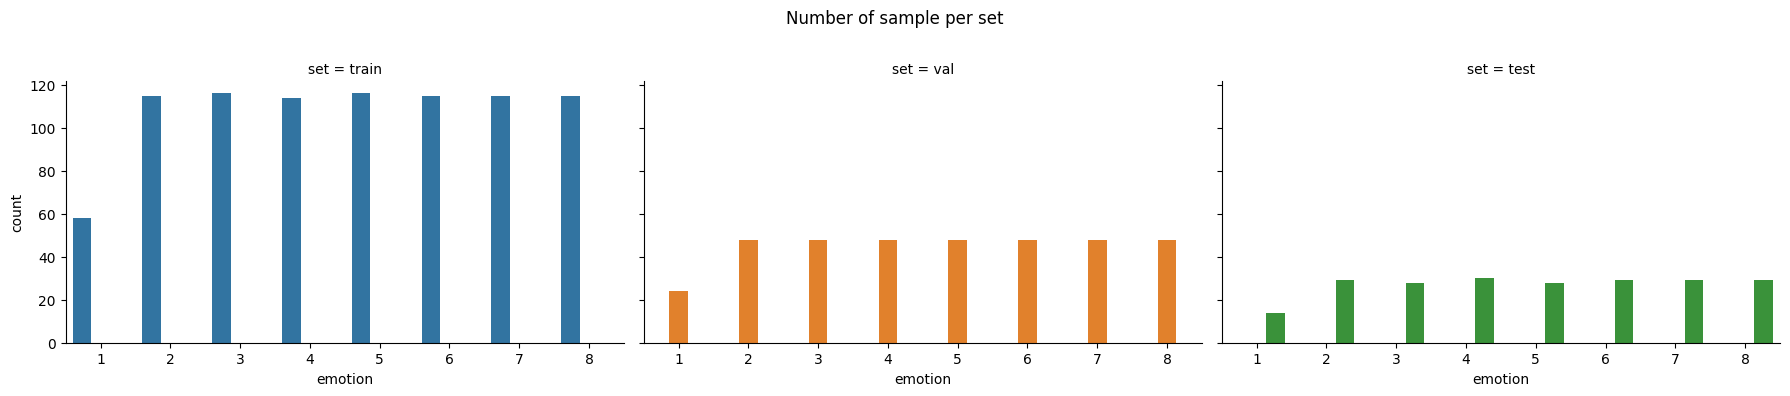

In [49]:
df_plot = pd.DataFrame(columns=['set', 'emotion'])

x = pd.DataFrame(len(df_train['features']) * ['train'])
y = pd.DataFrame(len(df_val['features']) * ['val'])
z = pd.DataFrame(len(df_test['features']) * ['test'])

p = pd.DataFrame(df_train['emotion'])
q = pd.DataFrame(df_val['emotion'])
r = pd.DataFrame(df_test['emotion'])

df_plot['set'] = pd.concat([x ,y, z], axis=0, ignore_index=True)
df_plot['emotion'] = pd.concat([p, q, r], axis=0, ignore_index=True)

g = sb.catplot(x='emotion', col='set', data=df_plot, kind='count', hue='set', height=4, aspect=1.5)
g.fig.suptitle("Number of sample per set")
g.fig.subplots_adjust(top=.8)
plt.show()

## Augmenting Training Data

In [ ]:
# train_aug = get_feature_dataframe(train, True)

In [ ]:
# df_train = pd.concat([df_train, train_aug], axis=0, ignore_index=True)

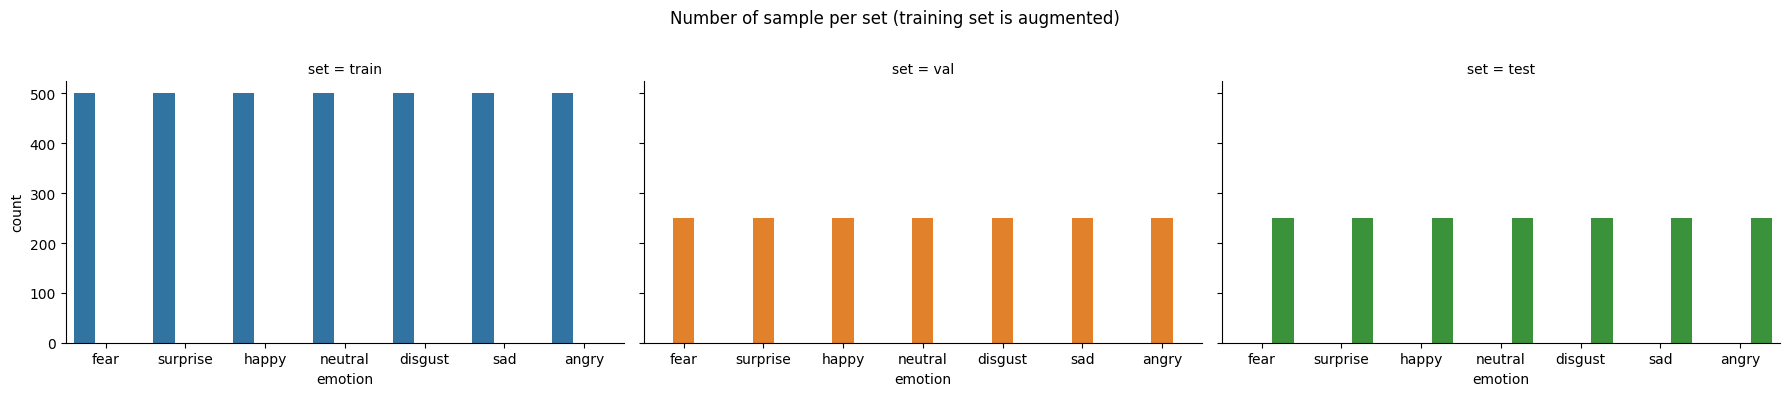

In [51]:
# df_plot = pd.DataFrame(columns=['set', 'emotion'])

# x = pd.DataFrame(len(df_train['features']) * ['train'])
# y = pd.DataFrame(len(df_val['features']) * ['val'])
# z = pd.DataFrame(len(df_test['features']) * ['test'])

# p = pd.DataFrame(df_train['emotion'])
# q = pd.DataFrame(df_val['emotion'])
# r = pd.DataFrame(df_test['emotion'])

# df_plot['set'] = pd.concat([x ,y, z], axis=0, ignore_index=True)
# df_plot['emotion'] = pd.concat([p, q, r], axis=0, ignore_index=True)

# g = sb.catplot(x='emotion', col='set', data=df_plot, kind='count', hue='set', height=4, aspect=1.5)
# g.fig.suptitle("Number of sample per set (training set is augmented)")
# g.fig.subplots_adjust(top=.8)

In [ ]:
# df_train = df_train.sample(frac=1).reset_index(drop=True)

In [50]:
save_path = f'./features/{ds}'
# os.makedirs(save_path)

np.save(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_train', df_train['features'])
np.save(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_train_emo', df_train['emotion'])
np.save(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_val', df_val['features'])
np.save(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_val_emo', df_val['emotion'])
np.save(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_test', df_test['features'])
np.save(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_test_emo', df_test['emotion'])

In [51]:
x_train = np.load(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_train.npy')
y_train = np.load(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_train_emo.npy')
x_val = np.load(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_val.npy')
y_val = np.load(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_val_emo.npy')
x_test = np.load(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_test.npy')
y_test = np.load(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_test_emo.npy')

In [52]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((864, 256, 400),
 (864, 1),
 (360, 256, 400),
 (360, 1),
 (216, 256, 400),
 (216, 1))

In [ ]:
# save_path = f'./features/{ds}'
# os.makedirs(save_path)

# df_train.to_csv(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_train.csv', index=False)
# df_val.to_csv(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_val.csv', index=False)
# df_test.to_csv(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_test.csv', index=False)

In [ ]:
# Load features from csv files.

# df_ft = pd.read_csv(f'./features/subesco/{ratio_train}-{ratio_val}-{ratio_test}/chroma_mfcc_mel_train.csv')

In [ ]:
#separating features and target outputs

# x_train = df_train.drop('emotion', axis = 1).values
# y_train = df_train['emotion'].values

# x_val = df_val.drop('emotion', axis = 1).values
# y_val = df_val['emotion'].values

# x_test = df_test.drop('emotion', axis = 1).values
# y_test = df_test['emotion'].values

In [ ]:
# x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((10500, 180), (10500,), (1750, 180), (1750,), (1750, 180), (1750,))

In [ ]:
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)
# x_val = scaler.transform(x_val)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((10500, 180), (10500,), (1750, 180), (1750,), (1750, 180), (1750,))

In [ ]:
# y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
# y_val = encoder.fit_transform(np.array(y_val).reshape(-1,1)).toarray()
# y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

In [ ]:
# x_train = np.expand_dims(x_train, axis=2)
# x_test = np.expand_dims(x_test, axis=2)
# x_val = np.expand_dims(x_val, axis=2)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((10500, 180, 1),
 (10500, 7),
 (1750, 180, 1),
 (1750, 7),
 (1750, 180, 1),
 (1750, 7))